In [75]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima.arima import ndiffs
from pmdarima.arima import CHTest
from pmdarima.arima import OCSBTest
from math import sqrt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
%matplotlib inline



#MLP
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
from datetime import datetime
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import keras
import warnings
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from numpy import array
%matplotlib inline


#https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [76]:
#def parser(x):
#    return datetime.strptime(x, "%Y-%m-%d")
#
#Explain tables properties




def read_data(filename):
    data = pd.read_csv(filename, usecols=[0,4], parse_dates=[0], header=0)
    plt.figure(figsize=[10, 5]); # Set dimensions for figure
    plt.plot(data['Date'], data['Close'])
    plt.title('$IBB closing price from Jan 2011 - Jan 2021')
    plt.ylabel('Price in $')
    plt.xlabel('Date')
    #plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
    return data
    
#IBBmonth = Path.cwd() / "Data" / "Raw" / "IBBmonth.csv"

    
#data = read_data("C:\Users\Andu\Documents\Final Project\Data\Raw\IBBmonth.csv")
data = pd.read_csv("C:\\Users\\Andu\\Documents\\Final Project\\Data\\Raw\\IBB.csv", usecols=[0,4], parse_dates=[0], header=0)

data.head()

,Date,Close
0,2011-01-11,31.820000
1,2011-01-12,31.993334
2,2011-01-13,32.023335
3,2011-01-14,32.070000
4,2011-01-18,32.423332


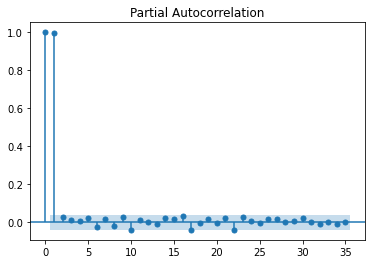

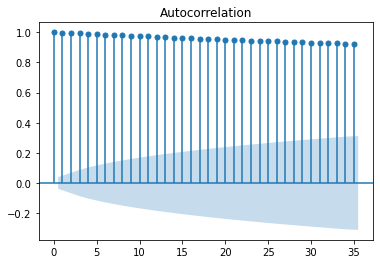

In [77]:
#Autocorrelation and Partial autocorrelation

plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [78]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(data['Close'])

(0.5506126087566047, True)

In [79]:
#Split dataset

def split_data(training_size):
    if training_size < 0 or training_size > 1:
        raise ValueError("Pease use a value between 0 and 1 to split the dataset. Recommended values for the size of the training dataset are: 0.50, 0.67, 0.80.")
    train_data, test_data = data[0:int(len(data)*training_size)], data[int(len(data)*training_size):]
    
    train_data = train_data['Close'].values
    test_data = test_data['Close'].values
    
    print("Number of training samples:", len(train_data))
    print("Number of testing samples:", len(test_data))
    return training_size, train_data, test_data
    
    
split_ratio, train_data, test_data = split_data(0.67)

Number of training samples: 1685
Number of testing samples: 831


In [80]:
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")




Estimated differencing term: 1


In [81]:
arima_model_test =  auto_arima(train_data,start_p=0, d=n_diffs, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, seasonal_test='ocsb', error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20, n_fits = 50)


print(arima_model_test)
print(arima_model_test.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5631.122, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5633.064, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5633.062, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5631.366, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5632.346, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.547 seconds
 ARIMA(0,1,0)(0,0,0)[0] intercept
(0, 1, 0)


In [82]:
# Ljung-Box test
#ljung_box, p_value = acorr_ljungbox(arima_model.resid)
#print(f'Ljung-Box test: {ljung_box[:10]}')
#print(f'p-value: {p_value[:10]}')

In [83]:
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=arima_model_test.order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)




In [84]:
def calculate_error_measures(X, Y):
        
    MSE = mean_squared_error(X, Y)
    print('Mean Squared Error: {}'.format(MSE))
    
    MAE = mean_absolute_error(X, Y)
    print('Mean Absolute Error: {}'.format(MAE))
    
    error_measures = [MSE, MAE]
    print(error_measures)
    return error_measures
    

print("Error measures for ARIMA:")
calculate_error_measures(test_data, model_predictions)

Error measures for ARIMA:
Mean Squared Error: 3.335136241545041
Mean Absolute Error: 1.3116471295079628
[3.335136241545041, 1.3116471295079628]


[3.335136241545041, 1.3116471295079628]

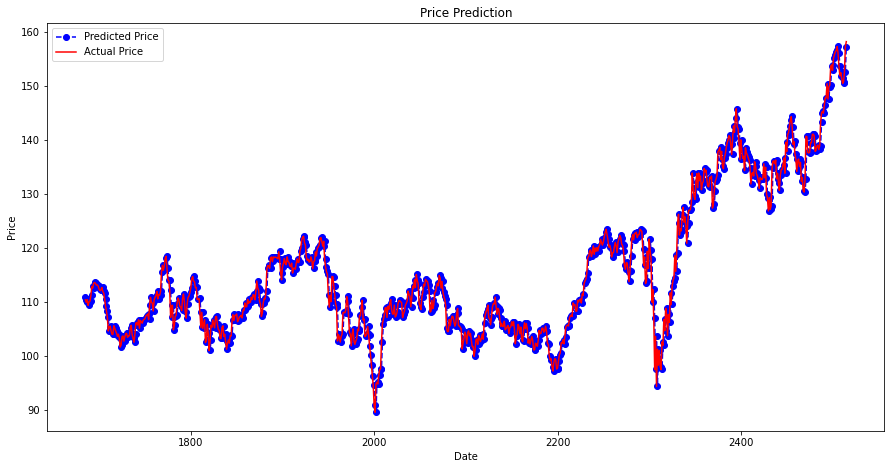

In [85]:
test_set_range = data[int(len(data)*split_ratio):].index
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [86]:
from sklearn.metrics import r2_score
r2_score(test_data, model_predictions)

0.9811956774859649

[1.         0.99765992 0.99546109 0.99333008 0.9912236  0.98921834
 0.98709331 0.98505024 0.9829241  0.98094548 0.97878582 0.97668064
 0.97460715 0.97249139 0.97050259 0.9685749  0.96681189 0.96485751
 0.9629012  0.96103012 0.95915181 0.95740191 0.9554467  0.95365126
 0.95189481 0.95013086 0.94846029 0.94684957 0.94527758 0.94369906
 0.94224093 0.94076684 0.93926608 0.93777632 0.93623296 0.9347151
 0.93310846 0.93145598 0.92986727 0.92830749 0.92673301 0.92513672
 0.9235605  0.92193099 0.92024459 0.91856313 0.91711601 0.91584867
 0.91448487 0.91308162 0.91169412 0.91023856 0.90882701 0.90738437
 0.90604746 0.90480434 0.90357479 0.90233683 0.90102635 0.89970962
 0.89826578 0.89686539 0.89546798 0.89406642 0.89262347 0.89123482
 0.88998827 0.88864148 0.88755254 0.88640149 0.88533073 0.88434442
 0.88335869 0.88237776 0.88147787 0.88056382 0.87956109 0.87856987
 0.87741281 0.87626067 0.8750946  0.87389594 0.87283492 0.87194478
 0.87100345 0.8700039  0.86907125 0.86815507 0.86715686 0.86607

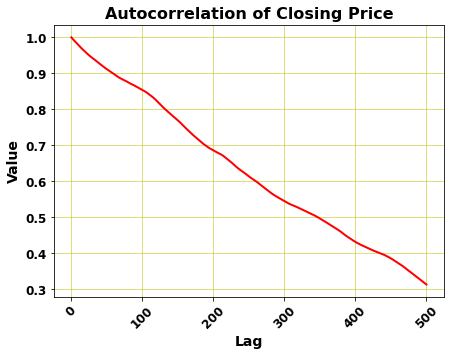

In [87]:
from statsmodels.tsa import stattools

acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(data['Close'],
                                                             unbiased=True,
                                                             nlags=500,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)


print(acf_djia)
num_of_steps = sum([1 for x in acf_djia if x>0.9])
print(num_of_steps)

In [88]:
#temp MLP

In [89]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [90]:
#Split test and train dataset

#
#train_data, test_data = train_test_split(data, test_size=0.33, shuffle = False, stratify = None)
#
#
#print(train_data.head())
#print(train_data.tail())
#print(test_data.head())
#print(train_data)
#
#test_data = test_data.reset_index(drop=True)
#train_data = test_data.reset_index(drop=True)

In [91]:
# define input sequence
raw_seq = train_data
print(raw_seq)
# choose a number of time steps
n_steps = num_of_steps
# split into samples
X, y = split_sequence(raw_seq, n_steps)

print(X,y)

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(80, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

model.summary()

# fit model
history = model.fit(X, y, epochs=2000, verbose=1)






[ 31.82      31.993334  32.023335 ... 110.723335 109.986664 110.916664]
[[ 31.82      31.993334  32.023335 ...  33.630001  33.713333  34.143333]
 [ 31.993334  32.023335  32.07     ...  33.713333  34.143333  34.146667]
 [ 32.023335  32.07      32.423332 ...  34.143333  34.146667  34.060001]
 ...
 [106.91333  106.573334 103.629997 ... 111.34333  110.686668 110.606667]
 [106.573334 103.629997 105.626663 ... 110.686668 110.606667 110.723335]
 [103.629997 105.626663 104.116669 ... 110.606667 110.723335 109.986664]] [ 34.146667  34.060001  34.066666 ... 110.723335 109.986664 110.916664]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 100)               6000      
_________________________________________________________________
dense_25 (Dense)             (None, 80)                8080      
____________________________________________________________

51/51 [==============================] - 0s 431us/step - loss: 6.0698 - mse: 6.0698 - mae: 1.7984
Epoch 59/2000
51/51 [==============================] - 0s 451us/step - loss: 4.3559 - mse: 4.3559 - mae: 1.5041
Epoch 60/2000
51/51 [==============================] - 0s 412us/step - loss: 4.8330 - mse: 4.8330 - mae: 1.6123
Epoch 61/2000
51/51 [==============================] - 0s 431us/step - loss: 4.4466 - mse: 4.4466 - mae: 1.5352
Epoch 62/2000
51/51 [==============================] - 0s 431us/step - loss: 4.1719 - mse: 4.1719 - mae: 1.4617
Epoch 63/2000
51/51 [==============================] - 0s 431us/step - loss: 4.6018 - mse: 4.6018 - mae: 1.5280
Epoch 64/2000
51/51 [==============================] - 0s 431us/step - loss: 6.4132 - mse: 6.4132 - mae: 1.8766
Epoch 65/2000
51/51 [==============================] - 0s 431us/step - loss: 5.9616 - mse: 5.9616 - mae: 1.7907
Epoch 66/2000
51/51 [==============================] - 0s 431us/step - loss: 4.7437 - mse: 4.7437 - mae: 1.5865
Epoch 

Epoch 131/2000
51/51 [==============================] - 0s 431us/step - loss: 3.8121 - mse: 3.8121 - mae: 1.3963
Epoch 132/2000
51/51 [==============================] - 0s 431us/step - loss: 3.5570 - mse: 3.5570 - mae: 1.3706
Epoch 133/2000
51/51 [==============================] - 0s 431us/step - loss: 5.0642 - mse: 5.0642 - mae: 1.6156
Epoch 134/2000
51/51 [==============================] - 0s 431us/step - loss: 3.0440 - mse: 3.0440 - mae: 1.2314
Epoch 135/2000
51/51 [==============================] - 0s 431us/step - loss: 3.6619 - mse: 3.6619 - mae: 1.3790
Epoch 136/2000
51/51 [==============================] - 0s 431us/step - loss: 3.9902 - mse: 3.9902 - mae: 1.4354
Epoch 137/2000
51/51 [==============================] - 0s 431us/step - loss: 4.8989 - mse: 4.8989 - mae: 1.6235
Epoch 138/2000
51/51 [==============================] - 0s 451us/step - loss: 3.9162 - mse: 3.9162 - mae: 1.4243
Epoch 139/2000
51/51 [==============================] - 0s 431us/step - loss: 3.6810 - mse: 3.68

51/51 [==============================] - 0s 431us/step - loss: 3.2578 - mse: 3.2578 - mae: 1.3097
Epoch 204/2000
51/51 [==============================] - 0s 431us/step - loss: 3.0933 - mse: 3.0933 - mae: 1.2702
Epoch 205/2000
51/51 [==============================] - 0s 431us/step - loss: 3.8638 - mse: 3.8638 - mae: 1.4642
Epoch 206/2000
51/51 [==============================] - 0s 431us/step - loss: 3.0805 - mse: 3.0805 - mae: 1.2625
Epoch 207/2000
51/51 [==============================] - 0s 451us/step - loss: 3.3877 - mse: 3.3877 - mae: 1.3283
Epoch 208/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6004 - mse: 2.6004 - mae: 1.1659
Epoch 209/2000
51/51 [==============================] - 0s 431us/step - loss: 2.5989 - mse: 2.5989 - mae: 1.1505
Epoch 210/2000
51/51 [==============================] - 0s 431us/step - loss: 3.7802 - mse: 3.7802 - mae: 1.4035
Epoch 211/2000
51/51 [==============================] - 0s 431us/step - loss: 2.9252 - mse: 2.9252 - mae: 1.240

51/51 [==============================] - 0s 431us/step - loss: 3.2681 - mse: 3.2681 - mae: 1.3120
Epoch 276/2000
51/51 [==============================] - 0s 431us/step - loss: 3.6274 - mse: 3.6274 - mae: 1.3983
Epoch 277/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6016 - mse: 2.6016 - mae: 1.1514
Epoch 278/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4644 - mse: 2.4644 - mae: 1.1180
Epoch 279/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4704 - mse: 2.4704 - mae: 1.1077
Epoch 280/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6789 - mse: 2.6789 - mae: 1.1811
Epoch 281/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5348 - mse: 2.5348 - mae: 1.1471
Epoch 282/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6493 - mse: 2.6493 - mae: 1.1720
Epoch 283/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4821 - mse: 2.4821 - mae: 1.138

51/51 [==============================] - 0s 451us/step - loss: 3.4570 - mse: 3.4570 - mae: 1.3494
Epoch 348/2000
51/51 [==============================] - 0s 431us/step - loss: 3.4093 - mse: 3.4093 - mae: 1.3525
Epoch 349/2000
51/51 [==============================] - 0s 451us/step - loss: 3.0328 - mse: 3.0328 - mae: 1.2642
Epoch 350/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3875 - mse: 2.3875 - mae: 1.0990
Epoch 351/2000
51/51 [==============================] - 0s 451us/step - loss: 3.2519 - mse: 3.2519 - mae: 1.3282
Epoch 352/2000
51/51 [==============================] - 0s 451us/step - loss: 2.7579 - mse: 2.7579 - mae: 1.1925
Epoch 353/2000
51/51 [==============================] - 0s 431us/step - loss: 2.7411 - mse: 2.7411 - mae: 1.2168
Epoch 354/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4324 - mse: 2.4324 - mae: 1.1229
Epoch 355/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6029 - mse: 2.6029 - mae: 1.148

51/51 [==============================] - 0s 431us/step - loss: 2.2495 - mse: 2.2495 - mae: 1.0647
Epoch 420/2000
51/51 [==============================] - 0s 431us/step - loss: 3.1859 - mse: 3.1859 - mae: 1.3097
Epoch 421/2000
51/51 [==============================] - 0s 431us/step - loss: 3.5101 - mse: 3.5101 - mae: 1.3677
Epoch 422/2000
51/51 [==============================] - 0s 451us/step - loss: 2.8401 - mse: 2.8401 - mae: 1.2300
Epoch 423/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4393 - mse: 2.4393 - mae: 1.1271
Epoch 424/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3061 - mse: 2.3061 - mae: 1.0930
Epoch 425/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3156 - mse: 2.3156 - mae: 1.1020
Epoch 426/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4734 - mse: 2.4734 - mae: 1.1261
Epoch 427/2000
51/51 [==============================] - 0s 431us/step - loss: 2.8290 - mse: 2.8290 - mae: 1.217

51/51 [==============================] - 0s 451us/step - loss: 2.7483 - mse: 2.7483 - mae: 1.2341
Epoch 492/2000
51/51 [==============================] - 0s 471us/step - loss: 2.5785 - mse: 2.5785 - mae: 1.1654
Epoch 493/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3846 - mse: 2.3846 - mae: 1.1127
Epoch 494/2000
51/51 [==============================] - 0s 431us/step - loss: 2.5594 - mse: 2.5594 - mae: 1.1591
Epoch 495/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5021 - mse: 2.5021 - mae: 1.1469
Epoch 496/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5373 - mse: 2.5373 - mae: 1.1533
Epoch 497/2000
51/51 [==============================] - 0s 431us/step - loss: 3.0281 - mse: 3.0281 - mae: 1.2846
Epoch 498/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4040 - mse: 2.4040 - mae: 1.1335
Epoch 499/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3884 - mse: 2.3884 - mae: 1.105

51/51 [==============================] - 0s 431us/step - loss: 3.2262 - mse: 3.2262 - mae: 1.3016
Epoch 564/2000
51/51 [==============================] - 0s 451us/step - loss: 3.0877 - mse: 3.0877 - mae: 1.2830
Epoch 565/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5204 - mse: 2.5204 - mae: 1.1520
Epoch 566/2000
51/51 [==============================] - 0s 431us/step - loss: 2.7261 - mse: 2.7261 - mae: 1.2051
Epoch 567/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4568 - mse: 2.4568 - mae: 1.1383
Epoch 568/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4851 - mse: 2.4851 - mae: 1.1457
Epoch 569/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3181 - mse: 2.3181 - mae: 1.1085
Epoch 570/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3623 - mse: 2.3623 - mae: 1.1223
Epoch 571/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6006 - mse: 2.6006 - mae: 1.158

51/51 [==============================] - 0s 451us/step - loss: 2.8032 - mse: 2.8032 - mae: 1.2420
Epoch 636/2000
51/51 [==============================] - 0s 471us/step - loss: 2.1706 - mse: 2.1706 - mae: 1.0469
Epoch 637/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5363 - mse: 2.5363 - mae: 1.1326
Epoch 638/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2807 - mse: 2.2807 - mae: 1.1040
Epoch 639/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3807 - mse: 2.3807 - mae: 1.1259
Epoch 640/2000
51/51 [==============================] - 0s 471us/step - loss: 2.1254 - mse: 2.1254 - mae: 1.0370
Epoch 641/2000
51/51 [==============================] - 0s 471us/step - loss: 2.5615 - mse: 2.5615 - mae: 1.1683
Epoch 642/2000
51/51 [==============================] - 0s 431us/step - loss: 3.4295 - mse: 3.4295 - mae: 1.3735
Epoch 643/2000
51/51 [==============================] - 0s 451us/step - loss: 3.0800 - mse: 3.0800 - mae: 1.274

51/51 [==============================] - 0s 431us/step - loss: 2.5181 - mse: 2.5181 - mae: 1.1392
Epoch 708/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6804 - mse: 2.6804 - mae: 1.1975
Epoch 709/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2549 - mse: 2.2549 - mae: 1.0688
Epoch 710/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2915 - mse: 2.2915 - mae: 1.0858
Epoch 711/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4027 - mse: 2.4027 - mae: 1.1293
Epoch 712/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2288 - mse: 2.2288 - mae: 1.0673
Epoch 713/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6808 - mse: 2.6808 - mae: 1.1808
Epoch 714/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1068 - mse: 2.1068 - mae: 1.0431
Epoch 715/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6813 - mse: 2.6813 - mae: 1.190

51/51 [==============================] - 0s 431us/step - loss: 2.4320 - mse: 2.4320 - mae: 1.1304
Epoch 780/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0386 - mse: 2.0386 - mae: 1.0031
Epoch 781/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3768 - mse: 2.3768 - mae: 1.1211
Epoch 782/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6543 - mse: 2.6543 - mae: 1.1795
Epoch 783/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5615 - mse: 2.5615 - mae: 1.1583
Epoch 784/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2951 - mse: 2.2951 - mae: 1.0875
Epoch 785/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1315 - mse: 2.1315 - mae: 1.0405
Epoch 786/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2423 - mse: 2.2423 - mae: 1.0679
Epoch 787/2000
51/51 [==============================] - 0s 431us/step - loss: 2.5212 - mse: 2.5212 - mae: 1.146

51/51 [==============================] - 0s 451us/step - loss: 2.2857 - mse: 2.2857 - mae: 1.0806
Epoch 852/2000
51/51 [==============================] - 0s 431us/step - loss: 4.6800 - mse: 4.6800 - mae: 1.6485
Epoch 853/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3538 - mse: 2.3538 - mae: 1.1013
Epoch 854/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2703 - mse: 2.2703 - mae: 1.0835
Epoch 855/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0947 - mse: 2.0947 - mae: 1.0293
Epoch 856/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2107 - mse: 2.2107 - mae: 1.0631
Epoch 857/2000
51/51 [==============================] - 0s 451us/step - loss: 3.7404 - mse: 3.7404 - mae: 1.4511
Epoch 858/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1744 - mse: 2.1744 - mae: 1.0668
Epoch 859/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1006 - mse: 2.1006 - mae: 1.043

51/51 [==============================] - 0s 451us/step - loss: 2.1232 - mse: 2.1232 - mae: 1.0414
Epoch 924/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3416 - mse: 2.3416 - mae: 1.0912
Epoch 925/2000
51/51 [==============================] - 0s 432us/step - loss: 2.1426 - mse: 2.1426 - mae: 1.0548
Epoch 926/2000
51/51 [==============================] - 0s 451us/step - loss: 2.9679 - mse: 2.9679 - mae: 1.2594
Epoch 927/2000
51/51 [==============================] - 0s 431us/step - loss: 3.0541 - mse: 3.0541 - mae: 1.2863
Epoch 928/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2314 - mse: 2.2314 - mae: 1.0712
Epoch 929/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5875 - mse: 2.5875 - mae: 1.1675
Epoch 930/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0519 - mse: 2.0519 - mae: 1.0250
Epoch 931/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0858 - mse: 2.0858 - mae: 1.019

51/51 [==============================] - 0s 451us/step - loss: 1.9888 - mse: 1.9888 - mae: 1.0113
Epoch 996/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2892 - mse: 2.2892 - mae: 1.0907
Epoch 997/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0195 - mse: 2.0195 - mae: 1.0165
Epoch 998/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0637 - mse: 2.0637 - mae: 1.0423
Epoch 999/2000
51/51 [==============================] - 0s 431us/step - loss: 2.5758 - mse: 2.5758 - mae: 1.1595
Epoch 1000/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2685 - mse: 2.2685 - mae: 1.0860
Epoch 1001/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0133 - mse: 2.0133 - mae: 1.0200
Epoch 1002/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6783 - mse: 2.6783 - mae: 1.2200
Epoch 1003/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2205 - mse: 2.2205 - mae: 1

51/51 [==============================] - 0s 451us/step - loss: 2.0834 - mse: 2.0834 - mae: 1.0300
Epoch 1068/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1006 - mse: 2.1006 - mae: 1.0423
Epoch 1069/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2999 - mse: 2.2999 - mae: 1.1042
Epoch 1070/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2786 - mse: 2.2786 - mae: 1.0837
Epoch 1071/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6113 - mse: 2.6113 - mae: 1.1705
Epoch 1072/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1424 - mse: 2.1424 - mae: 1.0509
Epoch 1073/2000
51/51 [==============================] - 0s 451us/step - loss: 2.6746 - mse: 2.6746 - mae: 1.1800
Epoch 1074/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3449 - mse: 2.3449 - mae: 1.1103
Epoch 1075/2000
51/51 [==============================] - 0s 431us/step - loss: 2.5847 - mse: 2.5847 - ma

51/51 [==============================] - 0s 431us/step - loss: 2.0550 - mse: 2.0550 - mae: 1.0283
Epoch 1140/2000
51/51 [==============================] - 0s 431us/step - loss: 2.9222 - mse: 2.9222 - mae: 1.2532
Epoch 1141/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3131 - mse: 2.3131 - mae: 1.0905
Epoch 1142/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1678 - mse: 2.1678 - mae: 1.0653
Epoch 1143/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1066 - mse: 2.1066 - mae: 1.0533
Epoch 1144/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4742 - mse: 2.4742 - mae: 1.1407
Epoch 1145/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1734 - mse: 2.1734 - mae: 1.0608
Epoch 1146/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4248 - mse: 2.4248 - mae: 1.1215
Epoch 1147/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2475 - mse: 2.2475 - ma

51/51 [==============================] - 0s 451us/step - loss: 2.4200 - mse: 2.4200 - mae: 1.1282
Epoch 1212/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0554 - mse: 2.0554 - mae: 1.0390
Epoch 1213/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4256 - mse: 2.4256 - mae: 1.1468
Epoch 1214/2000
51/51 [==============================] - 0s 451us/step - loss: 2.5358 - mse: 2.5358 - mae: 1.1638
Epoch 1215/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2158 - mse: 2.2158 - mae: 1.0834
Epoch 1216/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1832 - mse: 2.1832 - mae: 1.0514
Epoch 1217/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9201 - mse: 1.9201 - mae: 0.9759
Epoch 1218/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4192 - mse: 2.4192 - mae: 1.1133
Epoch 1219/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6212 - mse: 2.6212 - ma

51/51 [==============================] - 0s 431us/step - loss: 2.4533 - mse: 2.4533 - mae: 1.1361
Epoch 1283/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9439 - mse: 1.9439 - mae: 0.9990
Epoch 1284/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0995 - mse: 2.0995 - mae: 1.0362
Epoch 1285/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3952 - mse: 2.3952 - mae: 1.1302
Epoch 1286/2000
51/51 [==============================] - 0s 451us/step - loss: 4.9128 - mse: 4.9128 - mae: 1.6900
Epoch 1287/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9597 - mse: 1.9597 - mae: 0.9958
Epoch 1288/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0796 - mse: 2.0796 - mae: 1.0327
Epoch 1289/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1187 - mse: 2.1187 - mae: 1.0526
Epoch 1290/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2769 - mse: 2.2769 - ma

51/51 [==============================] - 0s 451us/step - loss: 1.9298 - mse: 1.9298 - mae: 0.9905
Epoch 1355/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6824 - mse: 2.6824 - mae: 1.1913
Epoch 1356/2000
51/51 [==============================] - 0s 431us/step - loss: 2.2800 - mse: 2.2800 - mae: 1.0893
Epoch 1357/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1897 - mse: 2.1897 - mae: 1.0703
Epoch 1358/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2147 - mse: 2.2147 - mae: 1.0753
Epoch 1359/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4373 - mse: 2.4373 - mae: 1.1545
Epoch 1360/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9380 - mse: 1.9380 - mae: 0.9912
Epoch 1361/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4518 - mse: 2.4518 - mae: 1.1316
Epoch 1362/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1325 - mse: 2.1325 - ma

51/51 [==============================] - 0s 431us/step - loss: 2.4632 - mse: 2.4632 - mae: 1.1456
Epoch 1427/2000
51/51 [==============================] - 0s 431us/step - loss: 2.8441 - mse: 2.8441 - mae: 1.2353
Epoch 1428/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1082 - mse: 2.1082 - mae: 1.0225
Epoch 1429/2000
51/51 [==============================] - 0s 431us/step - loss: 2.7046 - mse: 2.7046 - mae: 1.2110
Epoch 1430/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1853 - mse: 2.1853 - mae: 1.0552
Epoch 1431/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0587 - mse: 2.0587 - mae: 1.0321
Epoch 1432/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2742 - mse: 2.2742 - mae: 1.0819
Epoch 1433/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2479 - mse: 2.2479 - mae: 1.0796
Epoch 1434/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6997 - mse: 2.6997 - ma

51/51 [==============================] - 0s 431us/step - loss: 2.1334 - mse: 2.1334 - mae: 1.0602
Epoch 1499/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2949 - mse: 2.2949 - mae: 1.0861
Epoch 1500/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1214 - mse: 2.1214 - mae: 1.0572
Epoch 1501/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9004 - mse: 1.9004 - mae: 0.9947
Epoch 1502/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1846 - mse: 2.1846 - mae: 1.0570
Epoch 1503/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9942 - mse: 1.9942 - mae: 1.0245
Epoch 1504/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2572 - mse: 2.2572 - mae: 1.0771
Epoch 1505/2000
51/51 [==============================] - 0s 431us/step - loss: 2.1655 - mse: 2.1655 - mae: 1.0596
Epoch 1506/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9365 - mse: 1.9365 - ma

51/51 [==============================] - 0s 451us/step - loss: 2.2047 - mse: 2.2047 - mae: 1.0702
Epoch 1571/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1623 - mse: 2.1623 - mae: 1.0692
Epoch 1572/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9105 - mse: 1.9105 - mae: 0.9998
Epoch 1573/2000
51/51 [==============================] - 0s 431us/step - loss: 3.2992 - mse: 3.2992 - mae: 1.3546
Epoch 1574/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1717 - mse: 2.1717 - mae: 1.0750
Epoch 1575/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3642 - mse: 2.3642 - mae: 1.1167
Epoch 1576/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9185 - mse: 1.9185 - mae: 0.9978
Epoch 1577/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0110 - mse: 2.0110 - mae: 1.0229
Epoch 1578/2000
51/51 [==============================] - 0s 471us/step - loss: 2.2483 - mse: 2.2483 - ma

51/51 [==============================] - 0s 451us/step - loss: 2.2245 - mse: 2.2245 - mae: 1.0898
Epoch 1643/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0817 - mse: 2.0817 - mae: 1.0545
Epoch 1644/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4049 - mse: 2.4049 - mae: 1.1221
Epoch 1645/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2915 - mse: 2.2915 - mae: 1.0971
Epoch 1646/2000
51/51 [==============================] - 0s 451us/step - loss: 1.8938 - mse: 1.8938 - mae: 0.9776
Epoch 1647/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1235 - mse: 2.1235 - mae: 1.0513
Epoch 1648/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9967 - mse: 1.9967 - mae: 1.0320
Epoch 1649/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0218 - mse: 2.0218 - mae: 1.0159
Epoch 1650/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0206 - mse: 2.0206 - ma

51/51 [==============================] - 0s 471us/step - loss: 1.8451 - mse: 1.8451 - mae: 0.9810
Epoch 1715/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2447 - mse: 2.2447 - mae: 1.0909
Epoch 1716/2000
51/51 [==============================] - 0s 431us/step - loss: 2.4147 - mse: 2.4147 - mae: 1.1101
Epoch 1717/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9196 - mse: 1.9196 - mae: 0.9997
Epoch 1718/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0878 - mse: 2.0878 - mae: 1.0469
Epoch 1719/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1235 - mse: 2.1235 - mae: 1.0382
Epoch 1720/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0400 - mse: 2.0400 - mae: 1.0197
Epoch 1721/2000
51/51 [==============================] - 0s 431us/step - loss: 2.8731 - mse: 2.8731 - mae: 1.2217
Epoch 1722/2000
51/51 [==============================] - 0s 451us/step - loss: 2.8028 - mse: 2.8028 - ma

51/51 [==============================] - 0s 451us/step - loss: 2.7052 - mse: 2.7052 - mae: 1.2041
Epoch 1787/2000
51/51 [==============================] - 0s 431us/step - loss: 1.8627 - mse: 1.8627 - mae: 0.9813
Epoch 1788/2000
51/51 [==============================] - 0s 431us/step - loss: 1.7799 - mse: 1.7799 - mae: 0.9573
Epoch 1789/2000
51/51 [==============================] - 0s 431us/step - loss: 2.0703 - mse: 2.0703 - mae: 1.0271
Epoch 1790/2000
51/51 [==============================] - 0s 431us/step - loss: 1.8677 - mse: 1.8677 - mae: 0.9780
Epoch 1791/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9605 - mse: 1.9605 - mae: 1.0017
Epoch 1792/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0231 - mse: 2.0231 - mae: 1.0287
Epoch 1793/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3407 - mse: 2.3407 - mae: 1.1087
Epoch 1794/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1344 - mse: 2.1344 - ma

51/51 [==============================] - 0s 431us/step - loss: 1.9340 - mse: 1.9340 - mae: 1.0000
Epoch 1859/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9786 - mse: 1.9786 - mae: 1.0065
Epoch 1860/2000
51/51 [==============================] - 0s 431us/step - loss: 1.7871 - mse: 1.7871 - mae: 0.9529
Epoch 1861/2000
51/51 [==============================] - 0s 451us/step - loss: 2.3603 - mse: 2.3603 - mae: 1.1216
Epoch 1862/2000
51/51 [==============================] - 0s 451us/step - loss: 2.8593 - mse: 2.8593 - mae: 1.2470
Epoch 1863/2000
51/51 [==============================] - 0s 431us/step - loss: 2.3126 - mse: 2.3126 - mae: 1.1101
Epoch 1864/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9488 - mse: 1.9488 - mae: 1.0173
Epoch 1865/2000
51/51 [==============================] - 0s 451us/step - loss: 2.2755 - mse: 2.2755 - mae: 1.0908
Epoch 1866/2000
51/51 [==============================] - 0s 451us/step - loss: 2.7254 - mse: 2.7254 - ma

51/51 [==============================] - 0s 431us/step - loss: 1.8333 - mse: 1.8333 - mae: 0.9616
Epoch 1931/2000
51/51 [==============================] - 0s 451us/step - loss: 2.0902 - mse: 2.0902 - mae: 1.0405
Epoch 1932/2000
51/51 [==============================] - 0s 451us/step - loss: 1.9150 - mse: 1.9150 - mae: 1.0013
Epoch 1933/2000
51/51 [==============================] - 0s 451us/step - loss: 1.7732 - mse: 1.7732 - mae: 0.9407
Epoch 1934/2000
51/51 [==============================] - 0s 431us/step - loss: 1.9508 - mse: 1.9508 - mae: 1.0086
Epoch 1935/2000
51/51 [==============================] - 0s 431us/step - loss: 2.6036 - mse: 2.6036 - mae: 1.1847
Epoch 1936/2000
51/51 [==============================] - 0s 451us/step - loss: 2.1793 - mse: 2.1793 - mae: 1.0679
Epoch 1937/2000
51/51 [==============================] - 0s 451us/step - loss: 2.4355 - mse: 2.4355 - mae: 1.1439
Epoch 1938/2000
51/51 [==============================] - 0s 471us/step - loss: 2.1737 - mse: 2.1737 - ma

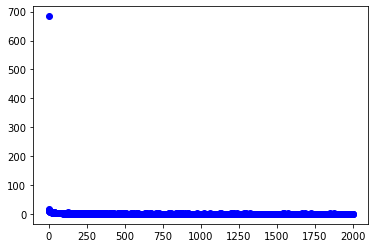

In [92]:
history_dict = history.history

loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'bo',label="training loss")
#plt.plot(val_loss_values,'r',label="val training loss")

In [93]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy


data_close = pd.DataFrame(data['Close'])
data_close.index = pd.to_datetime(data['Date'])

list_of_attributes = ['Close']

list_of_prev_t_instants = []
for i in range(1,num_of_steps):
    list_of_prev_t_instants.append(i)


df_new = create_regressor_attributes(data_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()
df_new.shape


(2458, 59)

In [94]:
# demonstrate prediction

#temp = train_data['Close']
#x_input, y_output = split_sequence(temp, n_steps)
#x_input = x_input[]
#x_input = x_input.values.reshape(n_steps, (n_steps:len(x_input)))


#x_input = test_data['Close']





#x_input = test_data
#x_input = x_input[:-1]
#x_shape = x_input.shape[0]
#x_input = x_input.reshape((30, n_steps))

#
#yhat = model.predict(test_data, verbose=1)
#
#print(yhat)
#
#
#predictions = pd.DataFrame.from_records(yhat, columns='predicted')
#predictions = predictions.reset_index(drop=True)


#actual = data[n_steps:len(data)]
#actual = actual.reset_index(drop=True)


In [95]:
MLP_test = test_data[:-1]
MLP_test = MLP_test
MLP_test = MLP_test[::3]

MLP_MSE = mean_squared_error(MLP_test, yhat)
print('Mean Squared Error: {}'.format(MLP_MSE))

MLP_MAE = mean_absolute_error(MLP_test, yhat)
print('Mean Absolute Error: {}'.format(MLP_MAE))

MLP_error = [MLP_MSE, MLP_MAE]
print(MLP_error)

ValueError: Found input variables with inconsistent numbers of samples: [277, 1]

In [ ]:
# MLP and REAL
y_output_3 = model_predictions[::3]
plt.plot(y_output_3, color="blue")
plt.plot(yhat, color="red")
plt.show()

In [ ]:
window_size=3
moving_average = pd.Series(test_data)


numbers_series = pd.Series(test_data)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

print(without_nans)

In [ ]:
plt.figure(figsize=[15, 7.5])
#actual
plt.plot(test_data, color="blue", marker="o")
#ARIMA
plt.plot(model_predictions, color="red", marker="_")
#MLP
plt.plot(yhat, color="green")
plt.plot(test_data, yhat, color='red', label='Actual Price')
#MA
plt.plot(without_nans, color="black")


In [ ]:

RA_MSE = mean_squared_error(MLP_test, data['pandas_SMA_3'])
print('Mean Squared Error: {}'.format(RA_MSE))

RA_MAE = mean_absolute_error(MLP_test, data['pandas_SMA_3'])
print('Mean Absolute Error: {}'.format(RA_MSE))

RA_error = [MLP_MSE, MLP_MAE]
print(RA_error)




#data['pandas_SMA_3']

In [ ]:
plt.bar(['ARIMA MSE', 'ARIMA MAE'], ARIMA_error)
plt.bar(['MLP_MSE','MLP_MAE'], MLP_error)

plt.ylabel('Error')
plt.title('Mean squared error and mean absolute error comparison')

plt.show()
